### Load the data

In [2]:
import torch
from transformer_lens import HookedTransformer, HookedTransformerConfig
from neel_plotly.plot import line
from helpers import loss_fn
from devinterp.slt.sampler import estimate_learning_coeff_with_summary, estimate_learning_coeff, SGLD
from devinterp.utils import plot_trace
import tqdm.auto as tqdm
import os
from pathlib import Path
from helpers import rolling_average

CREATE_ESTIMATES = True
TUNE_HYPERPARAMS = False

device = "cuda" if torch.cuda.is_available() else "cpu"
RAND_SEED = 42

if CREATE_ESTIMATES:
    LOAD_LOCATION = "../saves/check_point_50/grokking_add_multi_0.3.pth"

    cached_data = torch.load(LOAD_LOCATION, weights_only=False)

    state_dict = cached_data['model']
    model_checkpoints = cached_data["checkpoints"]
    checkpoint_epochs = cached_data["checkpoint_epochs"]
    test_losses = cached_data['test_losses']
    train_losses = cached_data['train_losses']
    add_test_losses = cached_data['add_test_losses']
    multi_test_losses = cached_data['multi_test_losses']
    max_nums = cached_data['max_nums']
    mod_value = cached_data['mod_value']
    train_frac = cached_data['train_frac']
    addition_frac = cached_data['addition_frac']
    train_data = cached_data['train_data']
    train_labels = cached_data['train_labels']

    print(f"train_frac = {train_frac} addition_frac = {addition_frac}")
    print(f"len(train_losses) = {len(train_losses)} len(test_losses) = {len(test_losses)} len(model_checkpoints) = {len(model_checkpoints)}")

train_frac = 0.5 addition_frac = 0.3
len(train_losses) = 6000 len(test_losses) = 6000 len(model_checkpoints) = 120


In [3]:
from torch.utils.data import TensorDataset, DataLoader
if CREATE_ESTIMATES:
    train_loader = DataLoader(TensorDataset(train_data, train_labels), batch_size=32, shuffle=True)

### Setup the Model

In [4]:
if CREATE_ESTIMATES:
    cfg = HookedTransformerConfig(
        n_layers = 1,
        n_heads = 4,
        d_model = 128,
        d_head = 32,
        d_mlp = 512,
        act_fn = "relu",
        normalization_type="LN",
        d_vocab=max_nums+1,
        d_vocab_out=mod_value,
        n_ctx= 3,
        init_weights=True,
        device=device,
        seed = RAND_SEED,
    )

    model = HookedTransformer(cfg)

### Local Learning Coefficient (RLCT) Estimation

#### Config

In [5]:
lr = 3e-2
num_chains = 3
num_draws = 150
num_burnin_steps = 50
num_steps_bw_draws = 1
gamma = 5
nbeta = 1.6
sampling_method = "sgld"

def evaluate(model, data):
    inputs, outputs = data

    return loss_fn(model(inputs), outputs), {
        "logits": model(inputs)
    }

#### Find the right hyperparameters

In [6]:
import typing
from typing import Type

import numpy as np


def estimate_llc_given_model(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    evaluate: typing.Callable,
    epsilon: float,
    beta: float,
    sampling_method: Type[torch.optim.Optimizer] = SGLD,
    localization: float = 5.0,
    num_chains: int = 3,
    num_draws: int = 500,
    num_burnin_steps: int = 0,
    num_steps_bw_draws: int = 1,
    device: torch.device = torch.device("cpu"),
    online: bool = True,
    verbose: bool = False,
):

    sweep_stats = estimate_learning_coeff_with_summary(
        model,
        loader=loader,
        evaluate=evaluate,
        sampling_method=sampling_method,
        optimizer_kwargs=dict(lr=epsilon, localization=localization, nbeta=beta),
        num_chains=num_chains,  # How many independent chains to run
        num_draws=num_draws,  # How many samples to draw per chain
        num_burnin_steps=num_burnin_steps,  # How many samples to discard at the beginning of each chain
        num_steps_bw_draws=num_steps_bw_draws,  # How many steps to take between each sample
        device=device,
        online=online,
        verbose=verbose,
    )

    sweep_stats["llc/trace"] = np.array(sweep_stats["llc/trace"])
    return sweep_stats

In [7]:
from devinterp.vis_utils import EpsilonBetaAnalyzer

if TUNE_HYPERPARAMS:
    model.load_state_dict(model_checkpoints[-1])
    analyzer = EpsilonBetaAnalyzer()
    analyzer.configure_sweep(
        llc_estimator=estimate_llc_given_model,
        llc_estimator_kwargs=dict(
            model=model,
            evaluate=evaluate,
            device=device,
            loader=train_loader,
        ),
        min_epsilon=3e-5,
        max_epsilon=3e-1,
        epsilon_samples=5,
        min_beta=None,
        max_beta=None,
        beta_samples=5,
        dataloader=train_loader,
    )
    analyzer.sweep()

In [8]:
if TUNE_HYPERPARAMS:
    analyzer.plot()

In [9]:
if TUNE_HYPERPARAMS:
    print(f"nbeta = {nbeta} gamma = {gamma} lr = {lr}")

    model.load_state_dict(model_checkpoints[60])

    results = estimate_learning_coeff_with_summary(
                    model,
                    loader=train_loader,
                    evaluate=evaluate,
                    sampling_method=SGLD if sampling_method == "sgld" else None,
                    optimizer_kwargs=dict(lr=lr, nbeta=nbeta, localization=gamma),
                    num_chains=num_chains,                  # How many independent chains to run
                    num_draws=num_draws,                    # How many samples to draw per chain
                    num_burnin_steps=num_burnin_steps,      # How many samples to discard at the beginning of each chain
                    num_steps_bw_draws=num_steps_bw_draws,  # How many steps to take between each sample
                    device=device,
                    online=True,
                )
    print(f"results.keys() = {results.keys()}")
    plot_trace(
        results["llc/trace"],
        "Loss",
        x_axis="Step",
        title=f"Loss Trace, avg LLC = {sum(results['llc/means']) / len(results['llc/means']):.2f}",
        plot_mean=False,
        plot_std=False,
        fig_size=(12, 9),
        true_lc=None,
    )

### Estimate for model checkpoints

In [10]:
from devinterp.slt.sampler import estimate_learning_coeff_with_summary, estimate_learning_coeff, SGLD
from devinterp.utils import plot_trace

def evaluate(model, data):
    inputs, outputs = data

    return loss_fn(model(inputs), outputs), {
        "logits": model(inputs)
    }

if CREATE_ESTIMATES:
    print(f"Addition frac = {addition_frac} Train frac = {train_frac}")
    print(f"nbeta = {nbeta} gamma = {gamma} lr = {lr}")
    llc_estimates = []

    for saved_model in tqdm.tqdm(model_checkpoints):
        model.load_state_dict(saved_model)
        result = estimate_learning_coeff_with_summary(
                    model,
                    loader=train_loader,
                    evaluate=evaluate,
                    sampling_method=SGLD if sampling_method == "sgld" else None,
                    optimizer_kwargs=dict(lr=lr, nbeta=nbeta, localization=gamma),
                    num_chains=num_chains,                  # How many independent chains to run
                    num_draws=num_draws,                    # How many samples to draw per chain
                    num_burnin_steps=num_burnin_steps,      # How many samples to discard at the beginning of each chain
                    num_steps_bw_draws=num_steps_bw_draws,  # How many steps to take between each sample
                    device=device,
                    online=False,
                )
        print(f"result['llc/mean'] = {result["llc/mean"]}")
        llc_estimates.append(result["llc/mean"])

Addition frac = 0.3 Train frac = 0.5
nbeta = 1.6 gamma = 5 lr = 0.03


  0%|          | 0/120 [00:00<?, ?it/s]

Moving model to device:  cpu
Moving model to device:  cpu


/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/slt/sampler.py:118: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(
/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:232: UserWarning: You are taking more draws than burn-in steps, your LLC estimates will likely be underestimates. Please check LLC chain convergence.
  warnings.warn(
/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:277: UserWarning: If you're setting a nbeta or temperature in optimizer_kwargs, please also make sure to set it in the callbacks.
  warnings.warn(
/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module impli

Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:01<00:00, 190.00it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:00<00:00, 216.72it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 200/200 [00:00<00:00, 209.26it/s]
/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/slt/sampler.py:118: UserWarning: Using passed in nbeta. Make sure callbacks are also initialized with the same nbeta.
  warnings.warn(


result['llc/mean'] = 16.479957580566406
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 200/200 [00:00<00:00, 211.60it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 200/200 [00:00<00:00, 227.52it/s]


Moving model to device:  cpu


Chain 2:   7%|▋         | 14/200 [00:00<00:00, 221.63it/s]


KeyboardInterrupt: 

### Save the data

In [314]:
SAVE_LOCATION = "../saves/check_point_50/llc_estimates_0.3.pth"

if CREATE_ESTIMATES:
    os.makedirs(Path(SAVE_LOCATION).parent, exist_ok=True)
    torch.save({
        "llc_estimates": llc_estimates,
        "lr": lr,
        "nbeta": nbeta,
        "gamma": gamma,
        "num_chains": num_chains,
        "num_draws": num_draws,
        "num_burnin_steps": num_burnin_steps,
        "num_steps_bw_draws": num_steps_bw_draws,
        "sampling_method": sampling_method,
        "train_frac": train_frac,
        "addition_frac": addition_frac,
        "LOAD_LOCATION": LOAD_LOCATION,
    }, SAVE_LOCATION)
    print(f"addition_frac = {addition_frac} train_frac = {train_frac}")
    print(f"Saved to {SAVE_LOCATION}")

addition_frac = 0.3 train_frac = 0.5
Saved to ../saves/check_point_50/llc_estimates_0.3.pth


### Load data

In [10]:
LOAD_DATA_PATH = "../saves/check_point_50/llc_estimates_0.5.pth"
if not CREATE_ESTIMATES:
    cached_data = torch.load(LOAD_DATA_PATH, weights_only=False)
    llc_estimates = cached_data['llc_estimates']
    lr = cached_data['lr']
    nbeta = cached_data['nbeta']
    gamma = cached_data['gamma']
    num_chains = cached_data['num_chains']
    num_draws = cached_data['num_draws']
    num_burnin_steps = cached_data['num_burnin_steps']
    num_steps_bw_draws = cached_data['num_steps_bw_draws']
    sampling_method = cached_data['sampling_method']
    train_frac = cached_data['train_frac']
    addition_frac = cached_data['addition_frac']
    training_data_path = cached_data['LOAD_LOCATION']
    print(f"addition_frac = {addition_frac} train_frac = {train_frac} len(llc_estimates) = {len(llc_estimates)}")
    print(f"Estimate created from {training_data_path}")

    training_data = torch.load(training_data_path, weights_only=False)
    train_losses = training_data['train_losses']
    test_losses = training_data['test_losses']
    add_test_losses = training_data['add_test_losses']
    multi_test_losses = training_data['multi_test_losses']
    print(f"len(train_losses) = {len(train_losses)} len(test_losses) = {len(test_losses)}")

addition_frac = 0.5 train_frac = 0.5 len(llc_estimates) = 120
Estimate created from ../saves/check_point_50/grokking_add_multi_0.5.pth
len(train_losses) = 6000 len(test_losses) = 6000


## Make some cool graphs

In [313]:
average_window = 5
llc_estimates_avg = rolling_average(llc_estimates, average_window)
line(llc_estimates, xaxis="Epoch", yaxis="LLC", title=f"LLC - addition_frac = {addition_frac} nbeta = {nbeta} epsilon = {lr} gamma = {gamma}", log_y=False, toggle_x=True, toggle_y=True)
line(llc_estimates_avg, xaxis="Epoch", yaxis="Rolling Average LLC", title="Learning Coefficient Estimates", log_y=False, toggle_x=True, toggle_y=True)

### Make graphs

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def load_cached_data(path, saves):
    for save in saves:
        # Load the data
        cached_data = torch.load(path + save, weights_only=False)
        llc_estimates = cached_data['llc_estimates']
        lr = cached_data['lr']
        nbeta = cached_data['nbeta']
        gamma = cached_data['gamma']
        num_chains = cached_data['num_chains']
        num_draws = cached_data['num_draws']
        num_burnin_steps = cached_data['num_burnin_steps']
        num_steps_bw_draws = cached_data['num_steps_bw_draws']
        sampling_method = cached_data['sampling_method']
        train_frac = cached_data['train_frac']
        addition_frac = cached_data['addition_frac']
        training_data_path = cached_data['LOAD_LOCATION']

        training_data = torch.load(training_data_path, weights_only=False)
        train_losses = training_data['train_losses']
        test_losses = training_data['test_losses']
        add_test_losses = training_data['add_test_losses']
        multi_test_losses = training_data['multi_test_losses']

        test_train_multiplier = len(test_losses) // len(llc_estimates)
        add_multi_multiplier = len(add_test_losses) // len(llc_estimates)

        llc_average_window = 4

        train_losses_avg = rolling_average(train_losses, llc_average_window * test_train_multiplier)
        test_losses_avg = rolling_average(test_losses, llc_average_window * test_train_multiplier)
        add_test_losses_avg = rolling_average(add_test_losses, llc_average_window * add_multi_multiplier)
        multi_test_losses_avg = rolling_average(multi_test_losses, llc_average_window * add_multi_multiplier)
        llc_estimates_avg = rolling_average(llc_estimates, llc_average_window)
        
        print(f"addition_frac = {addition_frac} train_frac = {train_frac}")
        #print(f"Estimate created from {training_data_path}")

        epochs_num = len(train_losses)
        test_train_x = np.arange(0, epochs_num, epochs_num // len(train_losses_avg))
        add_multi_x = np.arange(0, epochs_num, epochs_num // len(add_test_losses_avg))
        lc_epochs_x = np.arange(0, epochs_num, epochs_num // len(llc_estimates_avg))
        
        yield {
            'llc_estimates': llc_estimates,
            'lr': lr,
            'nbeta': nbeta,
            'gamma': gamma,
            'num_chains': num_chains,
            'num_draws': num_draws,
            'num_burnin_steps': num_burnin_steps,
            'num_steps_bw_draws': num_steps_bw_draws,
            'sampling_method': sampling_method,
            'train_frac': train_frac,
            'addition_frac': addition_frac,
            'training_data_path': training_data_path,
            'train_losses_avg': train_losses_avg,
            'test_losses_avg': test_losses_avg,
            'add_test_losses_avg': add_test_losses_avg,
            'multi_test_losses_avg': multi_test_losses_avg,
            'llc_estimates_avg': llc_estimates_avg,
            'test_train_x': test_train_x,
            'add_multi_x': add_multi_x,
            'lc_epochs_x': lc_epochs_x,
        }

# Path to the saved data
path = "../saves/check_point_50/"

#### Make individual graphs

In [ ]:
saves = [
    "llc_estimates_0.3.pth",
    "llc_estimates_0.35.pth",
    "llc_estimates_0.4.pth",
    "llc_estimates_0.45.pth",
    "llc_estimates_0.5.pth",
    "llc_estimates_0.55.pth",
    "llc_estimates_0.6.pth",
    "llc_estimates_0.65.pth",
    "llc_estimates_0.7.pth",
]

# Make individual graphs
for data in load_cached_data(path, saves):
    # Process the data
    llc_estimates = data['llc_estimates']
    lr = data['lr']
    nbeta = data['nbeta']
    gamma = data['gamma']
    num_chains = data['num_chains']
    num_draws = data['num_draws']
    num_burnin_steps = data['num_burnin_steps']
    num_steps_bw_draws = data['num_steps_bw_draws']
    sampling_method = data['sampling_method']
    train_frac = data['train_frac']
    addition_frac = data['addition_frac']
    training_data_path = data['training_data_path']
    train_losses_avg = data['train_losses_avg']
    test_losses_avg = data['test_losses_avg']
    add_test_losses_avg = data['add_test_losses_avg']
    multi_test_losses_avg = data['multi_test_losses_avg']
    llc_estimates_avg = data['llc_estimates_avg']
    test_train_x = data['test_train_x']
    add_multi_x = data['add_multi_x']
    lc_epochs_x = data['lc_epochs_x']

    print(f"addition_frac = {addition_frac} train_frac = {train_frac} len(llc_estimates) = {len(llc_estimates)}")
    print(f"Estimate created from {training_data_path}")    

    # Set up the plot
    plt.figure(figsize=(10, 6))
    sns.set_style("ticks")

    # Create the main axis
    ax1 = plt.gca()

    colors = sns.color_palette("colorblind")

    # Plot loss curves
    # ax1.plot(test_train_x, test_losses_avg, color=colors[0], label='Test Loss', linewidth=2)
    ax1.plot(test_train_x, train_losses_avg, color=colors[1], label='Train Loss', linewidth=2)
    ax1.plot(add_multi_x, add_test_losses_avg, color=colors[2], label='Addition Only Test Loss', linewidth=2)
    ax1.plot(add_multi_x, multi_test_losses_avg, color=colors[3], label='Multiplication Only Test Loss', linewidth=2)

    # Set up the second y-axis for learning coefficient
    ax2 = ax1.twinx()
    ax2.plot(lc_epochs_x, llc_estimates_avg, color=colors[4], linestyle='--', linewidth=2)

    # Customize the plot
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Rolling Avg Loss', fontsize=12)
    ax2.set_ylabel('Rolling Avg Learning Coefficient', fontsize=12)
    plt.title(f"Loss and LLC During Training - {addition_frac*100:.0f}% Addition - nbeta = {nbeta} epsilon = {lr}", fontsize=14)

    # Adjust tick parameters
    ax1.tick_params(axis='both', which='major', labelsize=10)
    ax2.tick_params(axis='y', which='major', labelsize=10)

    # Create a combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right') # bbox_to_anchor=(1.1, 1), fontsize=10)

    plt.tight_layout()

    # Save the plot to a PNG file
    plt.savefig(f'../graphs/loss_llc_training_{addition_frac}.png', format='png', dpi=300)
    plt.show()

#### Make side by side graphs

addition_frac = 0.5 train_frac = 0.5
addition_frac = 0.6 train_frac = 0.5
addition_frac = 0.7 train_frac = 0.5
addition_frac = 0.5 train_frac = 0.5 len(llc_estimates) = 120
Estimate created from ../saves/check_point_50/grokking_add_multi_0.5.pth
addition_frac = 0.6 train_frac = 0.5 len(llc_estimates) = 120
Estimate created from ../saves/check_point_50/grokking_add_multi_0.6.pth
addition_frac = 0.7 train_frac = 0.5 len(llc_estimates) = 120
Estimate created from ../saves/check_point_50/grokking_add_multi_0.7.pth


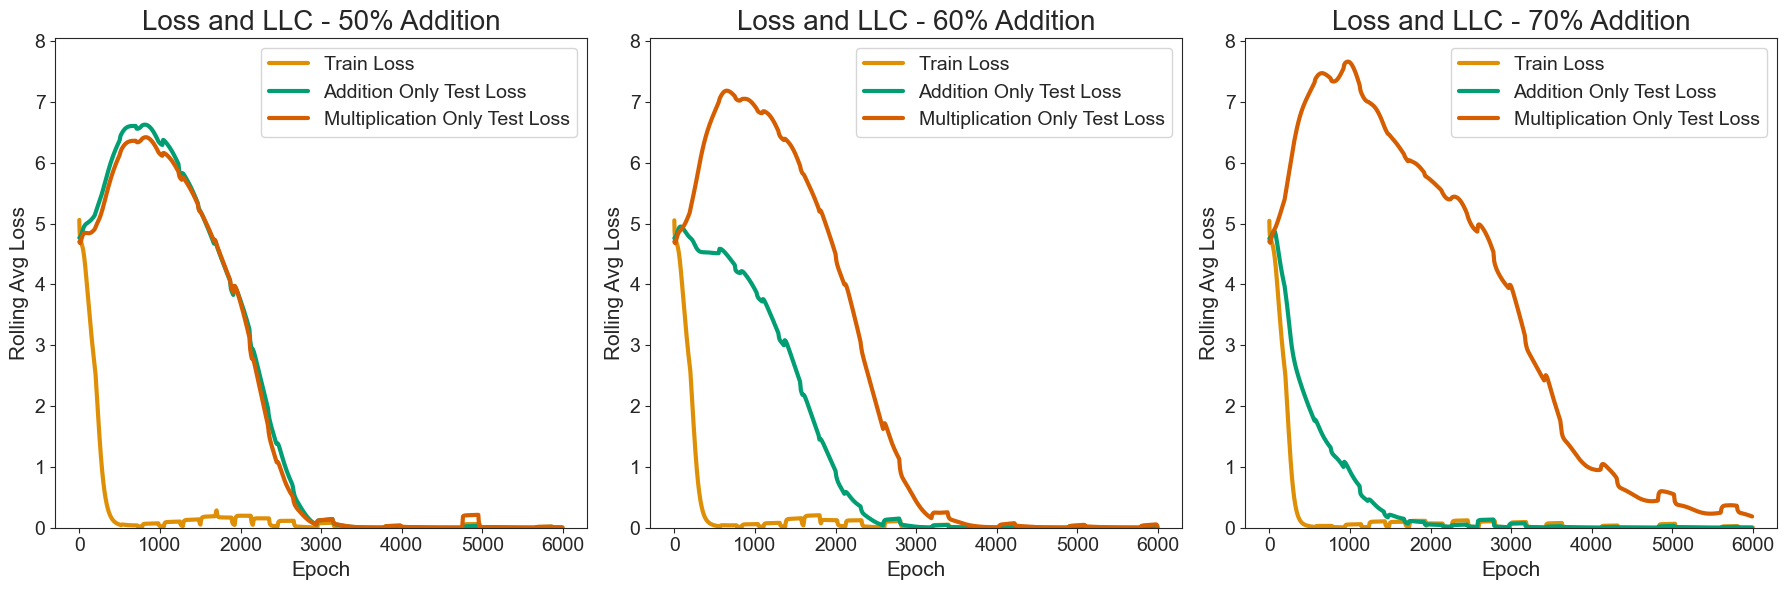

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

saves = [
    "llc_estimates_0.5.pth",
    "llc_estimates_0.6.pth",
    "llc_estimates_0.7.pth",
]

sns.set_style("ticks")

# Create a figure with 3 subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Load the datasets
datasets = list(load_cached_data(path, saves))

# Find the maximum loss for any of the datasets
max_loss = 0
for data in datasets:
    max_loss = max(max_loss, max(data['train_losses_avg']), max(data['add_test_losses_avg']), max(data['multi_test_losses_avg']))

max_loss = max_loss * 1.05

def create_plot(ax, data, max_loss):
    # Process the data
    llc_estimates = data['llc_estimates']
    train_frac = data['train_frac']
    addition_frac = data['addition_frac']
    training_data_path = data['training_data_path']
    train_losses_avg = data['train_losses_avg']
    add_test_losses_avg = data['add_test_losses_avg']
    multi_test_losses_avg = data['multi_test_losses_avg']
    test_train_x = data['test_train_x']
    add_multi_x = data['add_multi_x']

    print(f"addition_frac = {addition_frac} train_frac = {train_frac} len(llc_estimates) = {len(llc_estimates)}")
    print(f"Estimate created from {training_data_path}")

    colors = sns.color_palette("colorblind")
    
    # Plot loss curves
    ax.plot(test_train_x, train_losses_avg, color=colors[1], label='Train Loss', linewidth=3)
    ax.plot(add_multi_x, add_test_losses_avg, color=colors[2], label='Addition Only Test Loss', linewidth=3)
    ax.plot(add_multi_x, multi_test_losses_avg, color=colors[3], label='Multiplication Only Test Loss', linewidth=3)
    
    # Customize the plot
    ax.set_xlabel('Epoch', fontsize=15)
    ax.set_ylabel('Rolling Avg Loss', fontsize=15)
    ax.set_title(f"Loss and LLC - {addition_frac*100:.0f}% Addition", fontsize=20)

    # Set y-axis limit
    ax.set_ylim(0, max_loss)

    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Create a combined legend
    ax.legend(loc='upper right', fontsize=14)

# Create each subplot
for i, (ax, data) in enumerate(zip([ax1, ax2, ax3], datasets[:3])):
    create_plot(ax, data, max_loss)

plt.tight_layout()
plt.savefig('../graphs/combined_loss_llc_training.png', format='png', dpi=300)
plt.show()

#### Make LLC comparison graph

addition_frac = 0.3 train_frac = 0.5
addition_frac = 0.35 train_frac = 0.5
addition_frac = 0.4 train_frac = 0.5
addition_frac = 0.45 train_frac = 0.5
addition_frac = 0.5 train_frac = 0.5
addition_frac = 0.55 train_frac = 0.5
addition_frac = 0.6 train_frac = 0.5
addition_frac = 0.65 train_frac = 0.5
addition_frac = 0.7 train_frac = 0.5


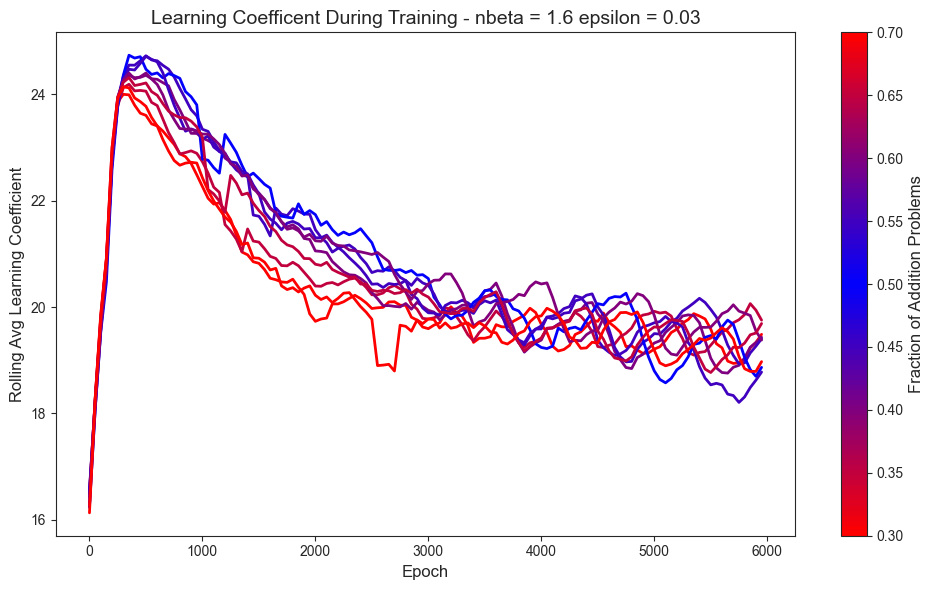

In [67]:
from matplotlib.colors import LinearSegmentedColormap

saves = [
    "llc_estimates_0.3.pth",
    "llc_estimates_0.35.pth",
    "llc_estimates_0.4.pth",
    "llc_estimates_0.45.pth",
    "llc_estimates_0.5.pth",
    "llc_estimates_0.55.pth",
    "llc_estimates_0.6.pth",
    "llc_estimates_0.65.pth",
    "llc_estimates_0.7.pth",
]

# Create a custom diverging colormap
colors = ['red', 'blue', 'red']
n_bins = 100  # Number of discrete color levels
cmap = LinearSegmentedColormap.from_list('custom_diverging', colors, N=n_bins)

data_list = list(load_cached_data(path, saves))

addition_fracs = [data['addition_frac'] for data in data_list]
min_addition_frac = min(addition_fracs)
max_addition_frac = max(addition_fracs)

# Set up the plot
plt.figure(figsize=(10, 6))
sns.set_style("ticks")

# Create the main axis
ax1 = plt.gca()

# Generate colors
norm = Normalize(vmin=min_addition_frac, vmax=max_addition_frac)
# cmap = plt.get_cmap('inferno')
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Plot llc_estimates_avg lines with different shades
for data in data_list:
    llc_estimates_avg = data['llc_estimates_avg']
    addition_frac = data['addition_frac']
    lc_epochs_x = data['lc_epochs_x']
    nbeta = data['nbeta']
    epsilon = data['lr']

    color = cmap(norm(addition_frac))
    ax1.plot(lc_epochs_x, llc_estimates_avg, color=color, label=f'Addition Frac: {addition_frac:.2f}', linewidth=2)

# Customize the plot
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Rolling Avg Learning Coefficient', fontsize=12)
plt.title(f'Learning Coefficent During Training - nbeta = {nbeta} epsilon = {epsilon}', fontsize=14)

# Create a vertical legend
cbar = plt.colorbar(sm, ax=ax1, orientation='vertical')
cbar.set_label('Fraction of Addition Problems', fontsize=12)

plt.savefig(f'../graphs/llc_during_training_all.png', format='png', dpi=300)
plt.tight_layout()
plt.show()